Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 86.4MB/s]



🧪 Epoch 1 | Train Loss: 1.2642
4    416
0      2
Name: count, dtype: int64

📊 Val — Acc: 0.5789 | Prec: 0.3154 | Rec: 0.2118 | F1: 0.1686
✅ Best model saved!

🧪 Epoch 2 | Train Loss: 1.1036
4    313
3     71
0     29
1      3
2      2
Name: count, dtype: int64

📊 Val — Acc: 0.5813 | Prec: 0.4872 | Rec: 0.3558 | F1: 0.3379
✅ Best model saved!

🧪 Epoch 3 | Train Loss: 0.9029
4    234
3     62
1     53
2     35
0     34
Name: count, dtype: int64

📊 Val — Acc: 0.5861 | Prec: 0.4770 | Rec: 0.4934 | F1: 0.4796
✅ Best model saved!

🧪 Epoch 4 | Train Loss: 0.7531
4    259
1     69
3     42
0     27
2     21
Name: count, dtype: int64

📊 Val — Acc: 0.6483 | Prec: 0.5628 | Rec: 0.5243 | F1: 0.5179
✅ Best model saved!

🧪 Epoch 5 | Train Loss: 0.6030
4    204
1     65
3     57
0     48
2     44
Name: count, dtype: int64

📊 Val — Acc: 0.6340 | Prec: 0.5544 | Rec: 0.6185 | F1: 0.5734

🧪 Epoch 6 | Train Loss: 0.4491
4    189
2     69
1     65
3     57
0     38
Name: count, dtype: int64

📊 Val — Acc: 

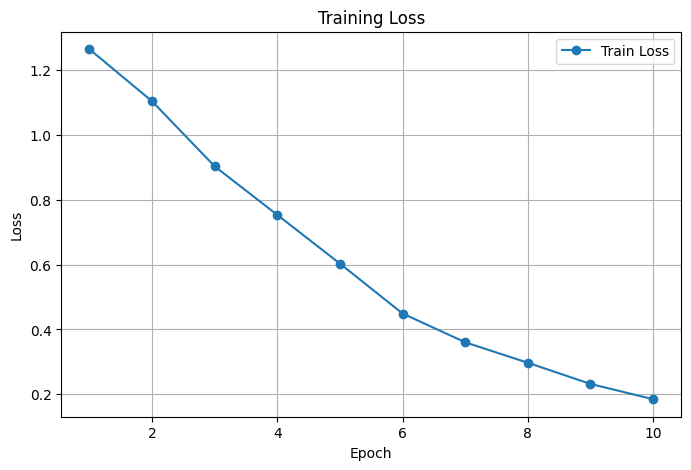

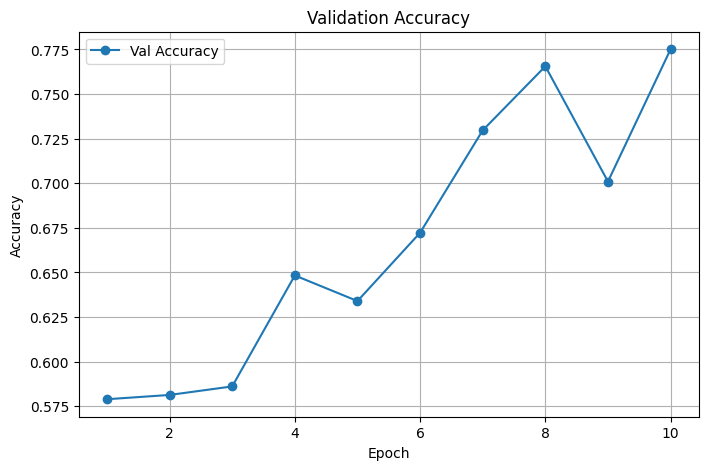

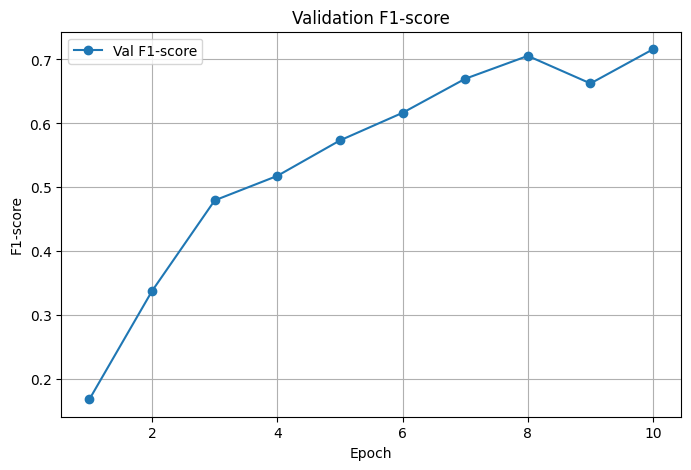

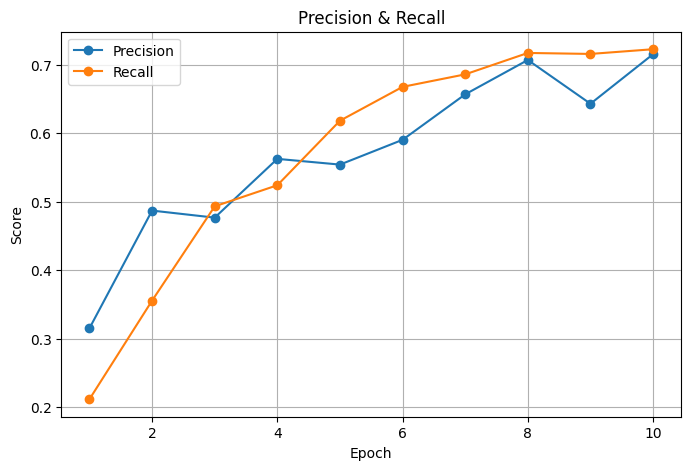

'/content/efficientnet_model_backup.zip'

In [1]:
import os
import torch
import torchaudio
import torchvision.models as models
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Dataset ====
class HeartbeatDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power')

        frame_duration = 512 / 16000
        target_duration = 20.0
        self.MAX_LEN = int(target_duration / frame_duration)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = torchaudio.load(row["filepath"])
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)

        mel_spec = self.mel_transform(waveform)
        mel_spec = self.db_transform(mel_spec)
        mel_spec = mel_spec.expand(3, -1, -1)  # EfficientNet expects 3 channels

        if mel_spec.shape[2] < self.MAX_LEN:
            mel_spec = nn.functional.pad(mel_spec, (0, self.MAX_LEN - mel_spec.shape[2]))
        else:
            mel_spec = mel_spec[:, :, :self.MAX_LEN]

        demo = torch.tensor([
            float(row["Age"]) / 100.0,
            float(row["Gender"]),
            float(row["Smoker"]),
            float(row["Lives"])
        ], dtype=torch.float)

        label = torch.tensor(int(row["class_id"]), dtype=torch.long)
        return mel_spec, demo, label

    def __len__(self):
        return len(self.df)

# ==== Collate ====
def collate_fn(batch):
    specs, demos, labels = zip(*batch)
    return torch.stack(specs), torch.stack(demos), torch.tensor(labels)

# ==== Model ====
class EfficientNetWithDemographics(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()  # Remove classifier to extract features
        self.demographic = nn.Linear(4, 32)
        self.classifier = nn.Sequential(
            nn.Linear(1536 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, demo):
        cnn_feat = self.cnn(x)
        demo_feat = self.demographic(demo)
        combined = torch.cat([cnn_feat, demo_feat], dim=1)
        return self.classifier(combined)

# ==== Build DataFrame ====
def build_dataframe(base_dir, metadata_csv):
    meta = pd.read_csv(metadata_csv)
    data = []
    class_mapping = {
        "aortic_regurgitation": 0,
        "aortic_stenosis": 1,
        "mitral_regurgitation": 2,
        "mitral_stenosis": 3,
        "multi_disease": 4
    }

    for class_name, class_id in class_mapping.items():
        folder_path = os.path.join(base_dir, class_name)
        for fname in os.listdir(folder_path):
            if fname.endswith(".wav"):
                patient_num = fname.split("_")[3]
                patient_id = f"patient_{patient_num}"
                match = meta[meta["Patient_id"] == patient_id]
                if not match.empty:
                    row = match.iloc[0].to_dict()
                    row["filepath"] = os.path.join(folder_path, fname)
                    row["class_id"] = class_id
                    data.append(row)

    return pd.DataFrame(data), class_mapping

# ==== Evaluate ====
def evaluate_model(model, val_loader, num_classes):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for x, demo, label in val_loader:
            x, demo = x.to(device), demo.to(device)
            logits = model(x, demo)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            true = label.numpy()
            preds.extend(pred)
            trues.extend(true)

    acc = accuracy_score(trues, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(trues, preds, average="macro", zero_division=0)
    print(pd.Series(preds).value_counts())
    print(f"\n📊 Val — Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    return acc, prec, rec, f1

# ==== Load Data ====
df, class_mapping = build_dataframe(
    "/content/drive/MyDrive/multi_classification_model_data",
    "/content/drive/MyDrive/multi_classification_model_data/metadata.csv"
)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["class_id"], random_state=42)
train_ds = HeartbeatDataset(train_df)
val_ds = HeartbeatDataset(val_df)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collate_fn)

# ==== Train ====
num_classes = len(class_mapping)
model = EfficientNetWithDemographics(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

train_losses, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
best_acc = 0

for epoch in range(10):
    model.train()
    total_loss = 0
    for x, demo, label in train_loader:
        x, demo, label = x.to(device), demo.to(device), label.to(device)
        logits = model(x, demo)
        loss = loss_fn(logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"\n🧪 Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")
    acc, prec, rec, f1 = evaluate_model(model, val_loader, num_classes)

    train_losses.append(avg_train_loss)
    val_accuracies.append(acc)
    val_precisions.append(prec)
    val_recalls.append(rec)
    val_f1s.append(f1)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_efficientnet_model.pth")
        print("✅ Best model saved!")

# ==== Plotting ====
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_accuracies, marker='o', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_f1s, marker='o', label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_precisions, marker='o', label='Precision')
plt.plot(epochs, val_recalls, marker='o', label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision & Recall')
plt.grid()
plt.legend()
plt.show()

# ==== Save Models ====
example_mel = torch.rand(1, 3, 64, 625).to(device)
example_demo = torch.rand(1, 4).to(device)

# Save state_dict
torch.save(model.state_dict(), "efficientnet_model_weights.pth")

# Save full model
torch.save(model, "efficientnet_model_full.pt")

# Save TorchScript
traced = torch.jit.trace(model, (example_mel, example_demo))
traced.save("efficientnet_model_scripted.pt")

# Save all into a folder and zip it
os.makedirs("exported_efficientnet_model", exist_ok=True)
shutil.move("efficientnet_model_weights.pth", "exported_efficientnet_model/")
shutil.move("efficientnet_model_full.pt", "exported_efficientnet_model/")
shutil.move("efficientnet_model_scripted.pt", "exported_efficientnet_model/")
shutil.make_archive("efficientnet_model_backup", 'zip', "exported_efficientnet_model")
